# Max Clique problem
Max clique problem is a classic NP-hard problem in Graph theory. The goal is to find the largest clique (a subset of vertices that form a complete subgraph) in a given undirected graph. <br>
This problem has applications in various fields, including:
* **Social network analysis**: Idnetifying highly connected communities.
* **Financial markets**: Detecting highly correlated asset groups for risk assessment and portfolio diversification.
* **Bioinformatics**: Detecting modules in protein-protein interaction networks.

## Problem Definition
Given a undirected graph **G=(V, E)** , where **V** is the set of vertices, **E** is the set of edges, representing connections between vertices. <br>
The objective is to find the largest clique **C** $\subseteq$ **V**, such that for any two vertices **u, v** $\in$ **C**, the edge (u, v) exists in **E**.

### max clique graph demo
![](./max_clique_demo.png)

### Define a function to generate graph

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Create a graph with known maximum clique
def generate_test_graph(weighted=False):
    edge_probability = 0.3  # Probability of edge creation
    n_nodes = 6  # Increased number of nodes
    G = nx.gnp_random_graph(n_nodes, edge_probability, seed=42)
    edge_weights = {(u, v): 1 for (u, v) in G.edges()} if weighted==False else {(u, v): random.uniform(0.5, 2.0) for (u, v) in G.edges()}
    nx.set_node_attributes(G, edge_weights, 'weight')
    return G, edge_weights

# QAOA (Quantum Approximate Optimization Algorithm)
QAOA is a hybrid quantum-classical algorithm designed to solve combinatorial optimization problems on near-term quantum devices. <br>
QAOA leverages variational quantum circuits to approximate the optimal solution to a given problem, making it particularly useful for NP-hard problems like Max-Cut, Max-Clique, and Graph Coloring. <br>
QAOA is a variational quantum algorithm (VQA), meaning it combines quantum circuits with classical optimization. <br>
The quantum circuit is parameterized and repeatedly updated using classical optimization techniques to maximize the expected value of the cost function .<br>

## Mathematica Formulation
The goal of QAOA is to find an approximate solution to a combinatorial optimization problem, which can be formulated as an Ising Hamiltonian: $H_C=\sum_{(i, j)\in E} C_{ij}Z_iZ_j$ <br>
where $Z_i$ is the Pauli-Z operator acting on qubit i, and $C_{ij}$ represents the cost function coefficients. The ground state of $H_C$ encodes the optimal solution. <br>
QAOA constructs a variational quantum state by alternating applications of two Hamiltonians: <br>

1. Cost Hamiltonian $H_C$: Encodes the objective function.
2. Mixing Hamiltonian $H_M$: Introduces transitions between states to explore the search space. <br>

By the Trotterization of $H_C$ and $H_M$ the QAOA state is given by: $\ket{\phi(\gamma, \beta)}=\prod_{k=1}^p e^{-i\beta_k H_M} e^{-i\gamma_k H_C} \ket{+}^{\otimes n}$ <br>
where:
* p is the QAOA depth (number of alternating layers).
* $\gamma=(\gamma_1, ..., \gamma_p)$ and $\beta=(\beta_1, ..., \beta_p)$ are variational parameters.
* The initial state $\ket{+}^{\otimes n}$ is the uniform superposition state.

In [2]:
from quri_parts.core.operator import Operator, pauli_label
import numpy as np


def get_hamiltonian_from_QUBO(Q):
    # Convert QUBO to Hamiltonian operator
    hamiltonian = Operator()
    max_i = max(i for i, j in Q.keys())
    max_j = max(j for i, j in Q.keys())
    for i in range(max_i):
        for j in range(i, max_j):
            if abs(Q[i, j]) > 1e-10:
                if i == j:
                    # Diagonal terms
                    hamiltonian.add_term(pauli_label(f"Z{i}"), Q[i, j] / 2)
                else:
                    # Off-diagonal terms
                    hamiltonian.add_term(pauli_label(f"Z{i} Z{j}"), Q[i, j] / 4)

    return hamiltonian


def get_QUBO_from_graph(G, weights):
    # Convert max clique to QUBO
    n = len(G.nodes())
    Q = {}
    for i in range(n):
        for j in range(i + 1, n):
            if not G.has_edge(i, j):
                Q[(i, j)] = 10  # Penalty for non-adjacent nodes
            else:
                Q[(i, i)] = weights[(i, j)] / 2  # Add edge weight contribution
                Q[(j, j)] = weights[(i, j)] / 2
                Q[(i, j)] = -weights[(i, j)]
    return Q

In [3]:
from utils import get_QUBO_from_graph, get_hamiltonian_from_QUBO

G, weights = generate_test_graph()
qubo = get_QUBO_from_graph(G, weights)
print(qubo)

{(0, 1): 10, (0, 0): 0.5, (2, 2): 0.5, (0, 2): -1, (3, 3): 0.5, (0, 3): -1, (4, 4): 0.5, (0, 4): -1, (0, 5): 10, (1, 2): 10, (1, 3): 10, (1, 1): 0.5, (1, 4): -1, (1, 5): 10, (2, 3): -1, (2, 4): -1, (2, 5): 10, (3, 4): -1, (5, 5): 0.5, (3, 5): -1, (4, 5): 10}



Exact maximum weighted clique: [3, 0, 2, 4]
Exact clique size: 4
Exact clique weight: 6


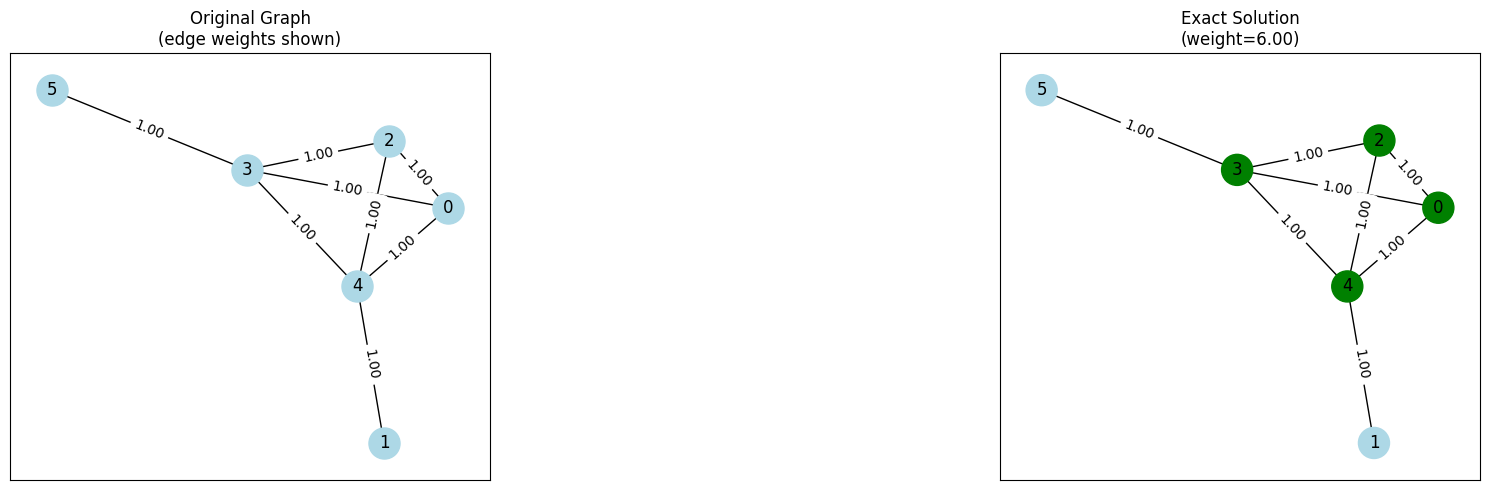

In [7]:
# import dimod
from networkx.algorithms.clique import find_cliques
edge_weights = weights
n = len(G.nodes())

# # Create BQM from QUBO
# bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)
# # Run simulated annealing using dimod's built-in sampler
# sampler = dimod.SimulatedAnnealingSampler()
# sampleset = sampler.sample(bqm, num_reads=200)
# # Get the best solution
# best_solution = sampleset.first.sample
# print("Best solution found (SA):", best_solution)
# print("Energy:", sampleset.first.energy)
# Extract the weighted clique from SA
# clique_sa = [node for node in range(n) if best_solution[node] == 1]
# clique_weight_sa = sum(edge_weights.get((min(u,v), max(u,v)), 0)
#                       for u in clique_sa for v in clique_sa if u < v)
# print("Maximum weighted clique found (SA):", clique_sa)
# print("Clique size (SA):", len(clique_sa))
# print("Clique weight (SA):", clique_weight_sa)
# Find exact solution using NetworkX and weights
all_cliques = list(find_cliques(G))
max_clique = max(all_cliques,
                 key=lambda clique: sum(edge_weights.get((min(u,v), max(u,v)), 0)
                                      for u in clique for v in clique if u < v))
max_clique_weight = sum(edge_weights.get((min(u,v), max(u,v)), 0)
                       for u in max_clique for v in max_clique if u < v)
print("\nExact maximum weighted clique:", max_clique)
print("Exact clique size:", len(max_clique))
print("Exact clique weight:", max_clique_weight)
# Plotting
plt.figure(figsize=(15, 5))
# Plot original graph with edge weights
plt.subplot(131)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
edge_labels = {(u,v): f"{edge_weights[(u,v)]:.2f}" for (u,v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Original Graph\n(edge weights shown)")
# Plot graph with highlighted SA clique
# plt.subplot(132)
# node_colors = ['red' if node in clique_sa else 'lightblue' for node in G.nodes()]
# nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
# nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# plt.title(f"SA Solution\n(weight={clique_weight_sa:.2f})")
# Plot graph with highlighted exact clique
plt.subplot(133)
node_colors = ['green' if node in max_clique else 'lightblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Exact Solution\n(weight={max_clique_weight:.2f})")
plt.tight_layout()
plt.show()

In [8]:
from QAOA import qaoa_trotter
hamiltonian = get_hamiltonian_from_QUBO(qubo)
n_qubits = len(G.nodes())
qaoa_states = qaoa_trotter(hamiltonian, n_qubits=n_qubits, n_steps=3, n_trotter=3)

ImportError: cannot import name 'LineSearchWarning' from 'scipy.optimize.linesearch' (c:\Users\User\anaconda3\envs\QC\lib\site-packages\scipy\optimize\linesearch.py)

In [15]:
print(qaoa_states)

OptimizerStateNFT(params=array([195.9858243 , 427.5554853 , 245.53471465, 314.69028265,
       181.16469449, 390.21708219]), cost=np.float64(-6.0352290253512075), status=<OptimizerStatus.CONVERGED: 3>, niter=1685, funcalls=20536, gradcalls=0)


In [16]:
clique_sa = [node for node in range(n) if qaoa_states.params[node] < 350]
clique_weight_sa = sum(edge_weights.get((min(u,v), max(u,v)), 0)
                      for u in clique_sa for v in clique_sa if u < v)
max_clique = max(all_cliques,
                 key=lambda clique: sum(edge_weights.get((min(u,v), max(u,v)), 0)
                                      for u in clique for v in clique if u < v))
max_clique_weight = sum(edge_weights.get((min(u,v), max(u,v)), 0)
                       for u in max_clique for v in max_clique if u < v)

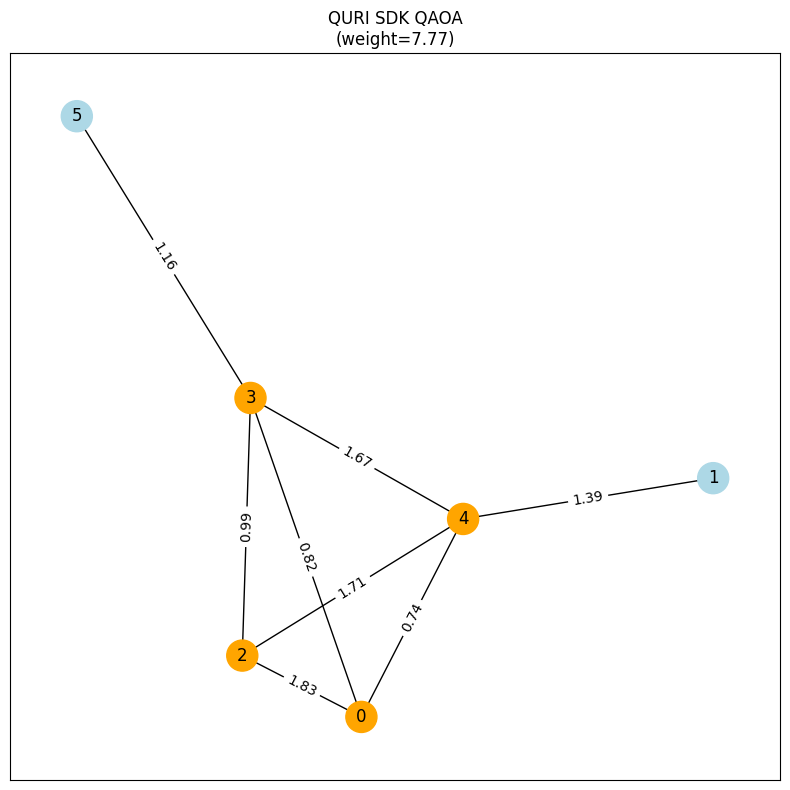

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(111)
node_colors = ['orange' if node in clique_sa else 'lightblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"QURI SDK QAOA\n(weight={max_clique_weight:.2f})")
plt.tight_layout()
plt.show()

In [8]:
print(clique_sa)

[]
